In [1]:
from typing import Any

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms as T
from torchvision.models.resnet import resnet18

from torchmetrics import Accuracy

import pytorch_lightning as L
from pytorch_lightning.utilities.types import STEP_OUTPUT

from wilds import get_dataset
from wilds.common.data_loaders import get_eval_loader, get_train_loader
from wilds.common.grouper import CombinatorialGrouper

from tqdm import tqdm

In [2]:
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def embed(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        c = x.mean(dim=[2,3])
        
        return c

In [3]:
transform = T.Compose([
    T.ToTensor()
])

In [4]:
class SimpleCNN(L.LightningModule):
    def __init__(self, in_channels=3, num_cls=2,*args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)

        self.model = CNN(in_channels=in_channels, num_classes=num_cls)

        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(params=self.parameters(), lr=1e-4)
        self.metric = Accuracy(num_classes=2, multiclass=True)

    def training_step(self, batch, batch_idx) -> STEP_OUTPUT:
        X, t, _ = batch

        y = self.model(X)
        loss = self.criterion(y, t)

        self.log("loss", loss)

        return loss
    
    def validation_step(self, batch, batch_idx) -> STEP_OUTPUT:
        X, t, _ = batch

        y = self.model(X).argmax(dim=1)
        
        accuracy = self.metric(y, t)

        self.log('accuracy', accuracy)

        return accuracy
    
    def configure_optimizers(self) -> Any:
        return self.optimizer

In [5]:
dataset = get_dataset("camelyon17", root_dir="../../data/")
train_set = dataset.get_subset("train", transform=transform)
val_set = dataset.get_subset("id_val", transform=transform)
test_set = dataset.get_subset('test', transform=transform)

grouper = CombinatorialGrouper(dataset, ['hospital'])

train_loader = get_train_loader("standard", train_set, grouper=grouper,uniform_over_groups=True, batch_size=64, num_workers=8)
val_loader = get_eval_loader('standard', val_set, batch_size=64, num_workers=8)
test_loader = get_eval_loader('standard', test_set, batch_size=64, num_workers=8)

In [6]:
trainer = L.Trainer(
    accelerator="auto", 
    max_epochs=10, 
    val_check_interval=int(len(train_loader)/3)
)

model = SimpleCNN(in_channels=3, num_cls=2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | CNN              | 271 K 
1 | criterion | CrossEntropyLoss | 0     
2 | metric    | Accuracy         | 0     
-----------------------------------------------
271 K     Trainable params
0         Non-trainable params
271 K     Total params
1.088     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [8]:
model_ = model.model.cuda()

In [9]:
source_set = dataset.get_subset("train", transform=transform, frac=10_000/len(train_set))
target_set = dataset.get_subset("test", transform=transform, frac=10_000/len(test_set))

source_loader = get_eval_loader("standard", source_set, batch_size=64, num_workers=8)
target_loader = get_eval_loader("standard", target_set, batch_size=64, num_workers=8)

In [10]:
source_embeddings = []
source_targets = []

target_embeddings = []
target_targets = []

with torch.no_grad():
    for X, t, _ in tqdm(source_loader):
        source_embeddings.append(model_.embed(X.cuda()).cpu())
        source_targets.append(t)

    for X, t, _ in tqdm(target_loader):
        target_embeddings.append(model_.embed(X.cuda()).cpu())
        target_targets.append(t)

source_embeddings = torch.cat(source_embeddings, dim=0)
source_targets = torch.cat(source_targets, dim=0)
target_embeddings = torch.cat(target_embeddings, dim=0)
target_targets = torch.cat(target_targets, dim=0)

100%|██████████| 157/157 [00:01<00:00, 94.22it/s] 


In [11]:
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [12]:
reducer = umap.UMAP(n_neighbors=15, n_epochs=1000, min_dist=0.1, verbose=True)

In [13]:
all_embeddings = torch.cat([source_embeddings, target_embeddings],dim=0).cpu()
all_targets = torch.cat([source_targets, target_targets], dim=0).cpu()

In [14]:
all_embeddings.shape, all_targets.shape

(torch.Size([20000, 32]), torch.Size([20000]))

In [15]:
X_scaled = StandardScaler().fit_transform(all_embeddings)

In [16]:
X_reduced = reducer.fit_transform(X_scaled)

UMAP(n_epochs=1000, verbose=True)
Tue Dec  5 19:47:10 2023 Construct fuzzy simplicial set
Tue Dec  5 19:47:10 2023 Finding Nearest Neighbors
Tue Dec  5 19:47:10 2023 Building RP forest with 12 trees
Tue Dec  5 19:47:12 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Tue Dec  5 19:47:18 2023 Finished Nearest Neighbor Search
Tue Dec  5 19:47:19 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Tue Dec  5 19:47:38 2023 Finished embedding


In [17]:
source_target = torch.cat([torch.zeros(10_000), torch.ones(10_000)])

In [18]:
color_values = torch.cat([source_target[None,:], all_targets[None,:]], dim=0)

In [19]:
color_values.shape

torch.Size([2, 20000])

In [20]:
color_map = {
    (0,0): "royalblue", # source, no_tumor
    (0,1): "mediumaquamarine", # source, tumor
    (1,0): "gold", # target, no_tumor
    (1,1): "goldenrod" # target, tumor
}

In [21]:
colors_master = [color_map[tuple(x.to(int).tolist())] for x in color_values.T]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


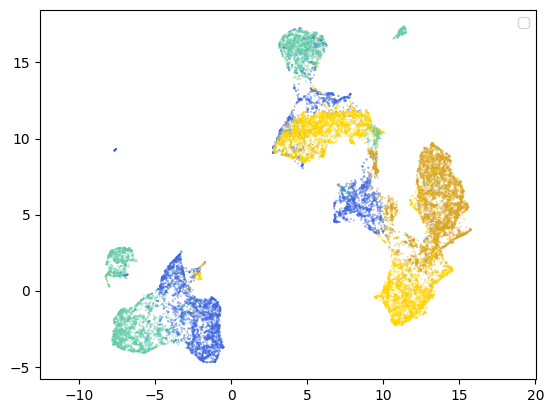

In [22]:
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=colors_master,
    s=0.05
)
plt.legend()
plt.gca().set_aspect('equal', 'datalim')